\section*{Problem Set 11}

\begin{eqnarray*}
& \max \mathbb{E} \sum_{t = 0}^{\infty} \beta^t u(c_t) \\
\text{subject to} & y_{t+1} = \xi_{t +1} f(y_t - c_t)
\end{eqnarray*}
with $u(x) = 1 - exp(-\theta x^{\gamma})$ and $f(x) = l(x) x^{\alpha}$ where $l$ is the logistic function. 

Bellmanized problem:
\begin{eqnarray*}
v(y_t,\xi_t) = & \max   u(c_t) +  \mathbb{E} \beta v(y_{t+1},\xi_{t+1}) \\
\text{subject to} & y_{t+1} = \xi_{t +1} f(y_t - c_t)
\end{eqnarray*}

with $log \xi_{t+1} \sim iid. N(-0.1,0.2)$

As we have iid shocks we only have to keep track of $y_t$:

\begin{eqnarray*}
v(y_t) = & \max   u(c_t) +  \mathbb{E} \beta v(\xi_{t +1} f(y_t - c_t)) 
\end{eqnarray*}

Howard iteration:

- Step I.: Guess $\sigma$
- Step II.: Iterate the Bellman operator to find $v_{\sigma}$  using numerical integration
- Step III.: Maximize $v_{\sigma}$ and find $\sigma'$ - use (vectorized) golden section search method

Both the value function and the policy function is approximated with cubic splines (with 20 nodes). In order to download the poly_base package go to: https://github.com/lt1245/poly_base .

In [1]:
import numpy as np
from scipy.stats import lognorm
import scipy.linalg as slin
from poly_base import interpolate as ip # toolbox for the project
import matplotlib.pyplot as plt
import time # To see how quickly it runs
%matplotlib inline

Parameter block

In [2]:
a = 1
b = 2
c = 20
d = 1
theta = 0.5
gamma = 0.9
alpha = 0.5
mu = - 0.1
sigma = 0.2 ** (1.0 / 2.0)
beta = 0.945
n_y = 25
n_xi = 100
xi_lower = 0.7
xi_upper = 2.5
y_lower = 0.001
y_upper = 10.0
y_grid = np.linspace(y_lower,y_upper,n_y)
xi_grid = np.linspace(xi_lower,xi_upper,n_xi) # Not optimal node placement
xi_grid = np.reshape(xi_grid,(n_xi,1))
P = np.array((n_y,y_grid[0],y_grid[-1])) #Interpolation object
degree = 3 # cubic splines

In [3]:
def utility(x):
    return 1-np.exp(-theta * x**gamma)
def l(x):
    return a + (b - a) / (1 + np.exp(-c * (x - d)))
def prod_fun(x):
    return x ** alpha * l(x)

Initial linear guess for the policy function

In [4]:
guess =    0.8 * y_grid

Evaluate cubic spline basis matrices and initial guess

In [5]:
Phi_y = ip.spli_basex(P,y_grid,deg = degree)
coeff_guess = slin.solve(Phi_y,guess)

Do the value function iteration step for a given policy (Step II.):

In [6]:
def value(sprime,coeff_v,order):
    Phi_sprime = ip.spli_basex(P,sprime,deg = degree,order = order)
    return Phi_sprime @ coeff_v 

In [7]:
def policy(coeff,Phi_y):
    return Phi_y @ coeff

In [8]:
def value_it(coeff,coeff_v):
    conv1 = 2.0
    iteration = 0
    yprime = prod_fun(y_grid - policy(coeff,Phi_y))
    sprime = np.multiply(xi_grid,yprime) 
    while conv1 > 1e-10:
        iteration = iteration +1
        value_1 =np.empty(sprime.shape)
        for i in range(n_xi):
            value_1[i,:] =  value(sprime[i,:],coeff_v,0)
        value_mass = np.multiply(np.repeat(lognorm.pdf(xi_grid, sigma, mu, np.exp(mu)),n_y,1),value_1) 
        value_expect = value_mass.sum(0) * (xi_upper - xi_lower)/ n_xi
        coeff_v_next = slin.solve(Phi_y,utility(policy(coeff,Phi_y)) + beta * value_expect)
        conv1 = np.sum(np.abs(coeff_v_next-coeff_v))
        np.copyto(coeff_v,coeff_v_next)
    return coeff_v

The maximization and updating step (Step III.):

In [9]:
def main_loop(coeff_guess):
    conv2 = 2.0
    iteration2 = 0
    coeff_v = value_it(coeff_guess,np.zeros(coeff_guess.shape))
    cons1 = policy(coeff_guess,Phi_y)
    while conv2 > 1e-6:
        iteration2 = iteration2 + 1
        def maximizand(cons):
            yprime = prod_fun(y_grid - cons)
            sprime = np.multiply(xi_grid,yprime) 
            value_1 =np.empty(sprime.shape)
            for i in range(n_xi):
                value_1[i,:] =  value(sprime[i,:],coeff_v,0)
            value_mass = np.multiply(np.repeat(lognorm.pdf(xi_grid, sigma, mu, np.exp(mu)),n_y,1),value_1) 
            value_expect = value_mass.sum(0) * (xi_upper - xi_lower)/ n_xi
            return utility(cons) + beta * value_expect
        cons_opt, value_opt = ip.goldenx(maximizand,y_lower*np.ones(y_grid.shape),y_grid,1e-8)
        coeff = slin.solve(Phi_y,cons_opt)
        coeff_v_next = slin.solve(Phi_y,value_opt)
        coeff_v = value_it(coeff,coeff_v_next)
        conv2 = np.sum(np.abs(cons_opt-cons1))
        np.copyto(cons1 , cons_opt)
        print(conv2)
    return coeff, coeff_v

Run the main loop to get the coefficients for the splines (consumption and value function):

In [10]:
start_time = time.time()
coeff, coeff_v = main_loop(coeff_guess)
print("--- %s seconds ---" % (time.time() - start_time))

21.3233468493
2.4454167453
0.111798473006
0.00678929261974
3.72287206607e-05
8.53798131195e-07
--- 35.53203225135803 seconds ---


\subsection*{Plotting}

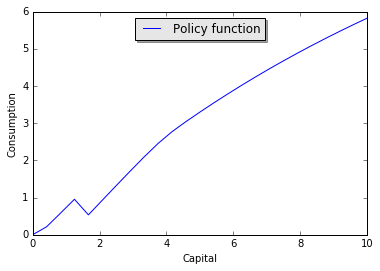

In [11]:
y_grid_fine = np.linspace(y_lower,y_upper,1 * n_y)
Phi_y_fine = ip.spli_basex(P,y_grid_fine,deg = degree)
cons_plot = policy(coeff,Phi_y_fine)
fig2, ax2 = plt.subplots()
ax2.plot(y_grid_fine,cons_plot, 'b-', label='Policy function')
legend = ax2.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.xlabel('Capital')
plt.ylabel('Consumption')
plt.show()